In [1]:
import re
import pandas as pd
import spacy
# !python -m spacy download es_core_news_sm
# !python -m spacy download es_dep_news_trf

In [2]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Spanish Verbs

In [ ]:
# Cargar el modelo en español
nlp = spacy.load("es_dep_news_trf")
# Cargar el archivo CSV
df = pd.read_json("json/isc_sentences.json")
print(df.shape)

/data/Workspace/thesis/venv/lib/python3.12/site-packages/thinc/shims/pytorch.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filelike,

(353, 7)


In [4]:
# Función para etiquetar las oraciones
def pos_tag(sentence):
    doc = nlp(sentence)
    return " ".join([f"{token.text}/{token.pos_}" for token in doc])


# Aplicar la función de etiquetado a la columna de oraciones
df['POS'] = df['spanish_sentence'].apply(pos_tag)

# Si no hay verbos o auxiliares en spanish_sentence, eliminar la fila
df_to_delete = df[~df['POS'].str.contains("VERB|AUX", regex=True)]

print(df.shape)
df = df[df['POS'].str.contains("VERB|AUX", regex=True)]
print(df.shape)

/data/Workspace/thesis/venv/lib/python3.12/site-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


(353, 8)
(296, 8)


In [5]:
# Función para extraer verbos (incluyendo compuestos y casos con solo auxiliares)
def extract_verbs(sentence):
    doc = nlp(sentence)
    verbs = []
    processed_tokens = set()  # Para hacer seguimiento de los verbos ya procesados
    for token in doc:
        # Ignorar símbolos o caracteres que no sean palabras alfabéticas
        if not token.is_alpha:
            continue
        
        # Detectar verbos compuestos (AUX + VERB)
        if token.pos_ == 'AUX' and token.head.pos_ == 'VERB' and token.dep_ == 'aux' and token.head.i not in processed_tokens:
            compound_verb = f"{token.text} {token.head.text}"
            verbs.append(compound_verb)
            processed_tokens.add(token.i)  # Marcar el auxiliar como procesado
            processed_tokens.add(token.head.i)  # Marcar el verbo principal como procesado
        # Detectar verbos individuales (que no sean parte de un compuesto)
        elif token.pos_ == 'VERB' and token.dep_ != 'aux' and token.i not in processed_tokens:
            verbs.append(token.text)
            processed_tokens.add(token.i)
        # Capturar auxiliares independientes (sin un verbo principal)
        elif token.pos_ == 'AUX' and token.head.pos_ != 'VERB' and token.i not in processed_tokens:
            verbs.append(token.text)
            processed_tokens.add(token.i)
    
    return verbs

# Aplicar la función para extraer los verbos de la columna 'spanish_sentence'
df['spanish_verbs'] = df['spanish_sentence'].apply(extract_verbs)

/data/Workspace/thesis/venv/lib/python3.12/site-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


In [ ]:
# Guardar como JSON
print(df.shape)
df.to_json("json/isc_sentences_with_spanish_verbs.json", orient="records", force_ascii=False)

(296, 9)


Tense:Future;Number:1;...

T:Fut;N:1;...

## Analizando

In [ ]:
df = pd.read_json("json/isc_sentences_with_spanish_verbs.json")
print(df.shape)

(296, 9)


In [ ]:
transitivity_features = ['TRAN', 'INT']
aspect_features = ['PERF', 'IMPF', 'HAB', 'PROG', 'EST', 'PF']
tense_features = ['todavía', 'DUR.mismo.día', 'DUR.noche.anterior',
                  'PAS.ayer', 'PAS.días', 'PAS.REM', 'PAS.REM.DUR',
                  'FUT.INM', 'FUT', 'PAS.REM.HAB']
mood_features = ['DUB', 'ASER', 'HAB', 'DES', 'IMP', 'EXH']
number_features = ['DUAL', 'PLU', 'PL']
negation_features = ['NEG', 'nunca', 'todavía.no', 'FRUS']
movement_features = ['VEN', 'VEN.TRAN', 'VEN.INT', 'ANDA', 'AND',
                     'dando.vuelta', 'pasando', 'bajando', 'subiendo',
                     'ITER', 'DUR', 'ir.a', 'viniendo']
reference_change_features = ['S/A>A', 'S/A>S']
other_features = ['ASOC', 'ENF', 'MAL', 'BEN', 'DIM', 'CAUS', 'REC', 'CAU']


abbreviations = transitivity_features + aspect_features + tense_features \
                + mood_features + number_features + negation_features \
                + movement_features + reference_change_features + other_features

# Función para verificar si una palabra contiene alguna abreviación
def extract_abbreviations(sentence, abbreviations):
    words = sentence.split()  # Dividimos la oración por espacios
    result = []
    
    for word in words:
        # Verificamos si alguna abreviación está en la palabra
        if any(abbr in word for abbr in abbreviations):
            result.append(word)
    
    return result

# Aplicamos la función a la columna 'annotated_sentence'
df['verb_abbreviations'] = df['annotated_sentence'].apply(lambda x: extract_abbreviations(x, abbreviations))

# ...

diff_long_list = []

# Ahora, mapeamos las palabras correspondientes de 'suffix_sentence'
def get_corresponding_words(row):
    annotated_words = row['verb_abbreviations']  # Las palabras extraídas con abreviaciones
    suffix_words = row['suffix_sentence'].split()  # Dividimos por espacios
    annotated_sentence_words = row['annotated_sentence'].split()  # Dividimos por espacios

    corresponding_words = []

    if len(suffix_words) != len(annotated_sentence_words):
        # print(f"Error: Las oraciones no tienen la misma longitud ({row['key']})")
        diff_long_list.append(row['key'])
        return []

    for word in annotated_words:
        # Buscar la palabra en la oración anotada
        if word not in annotated_sentence_words:
            print(f"Error: La palabra '{word}' no está en la oración anotada ({row['index']})")
            continue
        index = annotated_sentence_words.index(word)
        # Obtener la palabra correspondiente de 'suffix_sentence'
        corresponding_words.append(suffix_words[index])

    return corresponding_words


# Aplicamos la función para obtener la lista de palabras de 'suffix_sentence' en la misma posición
df['iskonawa_verb_segmented'] = df.apply(get_corresponding_words, axis=1)

def join_segmented_words(words):
    return [word.replace('-', '') for word in words if word != '']

print("diff_long_list:", diff_long_list)
# Mostrar el DataFrame filtrado con las nuevas columnas
# df[['key', 'suffix_sentence', 'annotated_sentence', 'POS', 'reference', 'verb_abbreviations', 'suffix_corresponding_words']]


diff_long_list: ['BGLI57', 'BGLI63', 'BGLI110', 'BGLI121', 'BGLI131', 'BGLI132', 'BGLI140', 'BGLI144', 'BGLI151', 'BGLI152', 'BGLI223', 'PPCI36a', 'PPCI37', 'BGLI215']


In [1205]:
from utils.visualization import print_row
print_row(df, key="BGLI132")


key: BGLI132
iskonawa_sentence:	 Jose Antonio amenkiri bebah beni beni ikerani
suffix_sentence:	 Jose Antonio amenkiri beba-ah beni beni ik-keran-i
spanish_sentence:	 José Antonio viene después de haber estado molesto, sentado solo
annotated_sentence:	 José Antonio él.solo sentarse-SUJ.IDEN:S molesto ser-VEN.INT-IMPF
	"BGLI132": {
		"verb_abbreviations":	 ['ser-VEN.INT-IMPF'] ,
		"iskonawa_verb_segmented":	 [] ,
		"spanish_verbs":	 ['viene', 'haber', 'estado']
	},


In [1206]:
# Diccionario con los valores a asignar
updates = {
  # "BGLI52": {
  #   "verb_abbreviations": ["ver-PERF"],
  #   "iskonawa_verb_segmented": ["oin-a"]
  # },
  "BGLI57": { "iskonawa_verb_segmented": ["ka-i"] },
  "BGLI58": {  "verb_abbreviations": ["ver-HAB ver-HAB-IMPF"],
             "iskonawa_verb_segmented": ["oin-s oin-s-i"] },
  "BGLI61": {  "verb_abbreviations": ["ver-HAB ver-HAB-IMPF"],
             "iskonawa_verb_segmented": ["oin-s oin-s-i"] },
  "BGLI63": { "iskonawa_verb_segmented": ["ka-i"] },
  "BGLI64": {  "verb_abbreviations": ["ver-HAB ver-HAB-IMPF"],
             "iskonawa_verb_segmented": ["oin-s oin-s-i"] },
  # 0	BGLI64	[ver-HAB, ver-HAB-IMPF]	[mira]	[oin-s, oin-s-i]
  "BGLI69": {
    "verb_abbreviations": ["beber-PERF"],
    "iskonawa_verb_segmented": ["ai-a"]
  },
  "BGLI71": {
    "verb_abbreviations": ["llamar-PERF"],
    "iskonawa_verb_segmented": ["ken-a"]
  },
  "BGLI72": { "spanish_verbs": ["cruzó"] },
  "BGLI73": {
    "spanish_verbs": ["Yendo", "matando", "hacía comer"],
    "iskonawa_verb_segmented": ["ka-hun", "a-hon", "pi-kin-kin"]
  },
  "BGLI74": { "spanish_verbs": ["maté y vine"] },
  "BGLI75": { "spanish_verbs": ["maté y vine"] },
  "BGLI76": { "spanish_verbs": ["bañé y vine"] },
  "BGLI97": { "spanish_verbs": ["era"] },
  "BGLI91": { "spanish_verbs": ["duermo"] },
  "BGLI95": {
    "verb_abbreviations": ["tener.miedo-IMPF"],
    "spanish_verbs": ["tengo miedo"],
    "iskonawa_verb_segmented": ["pari-i"]
  },
  "BGLI101": { "spanish_verbs": ["caminé"] },
  "BGLI109": {
    "verb_abbreviations": ["vivir-PERF"],
    "iskonawa_verb_segmented": ["ewe-a"]
  },
  "BGLI110": {
    "verb_abbreviations": ["atacar-PERF"],
    "iskonawa_verb_segmented": ["pian ak-a"]
  },
  "BGLI111": {
    "verb_abbreviations":	 ['matar-PERF'],
    "iskonawa_verb_segmented":	 ['rete-a'],
    "spanish_verbs":	 ['mató']
  },
  "BGLI112": {
    'verb_abbreviations':	 ['venir-PERF'],
    'iskonawa_verb_segmented':	 ['o-a'],
    'spanish_verbs':	 ['vino']
  },
  "BGLI120": { "spanish_verbs": ["comí"] },
  "BGLI121": { "iskonawa_verb_segmented": ["heri heri ik-i"] },
  "BGLI125": {
		"verb_abbreviations":	 ['ver-PERF'] ,
		"iskonawa_verb_segmented":	 ['oin-a'] ,
		"spanish_verbs":	 ['vi']
	},
  "BGLI130": {
		"verb_abbreviations":	 ['molesto molesto ser-IMPF'] ,
		"iskonawa_verb_segmented":	 ['beni beni ik-i'] ,
		"spanish_verbs":	 ['está molesto']
	},    
  "BGLI131": { "iskonawa_verb_segmented": ["beni beni ik-i"] },
  "BGLI132": {
    "verb_abbreviations": ["molesto ser-VEN.INT-IMPF"],
    "iskonawa_verb_segmented": ["beni beni ik-keran-i"],
    "spanish_verbs": ["haber estado molesto"]
  },
  "BGLI134": { "spanish_verbs": ["ha golpeado"] },
  "BGLI135": { "spanish_verbs": ["ha golpeado"] },
  "BGLI136": { "spanish_verbs": ["ha golpeado"] },
  "BGLI139": { "spanish_verbs": ["quiero comer"] },
  "BGLI140": {
    "verb_abbreviations": ["ver-S/A>S", "desear-IMPF"],
    "iskonawa_verb_segmented": ["oin-ah", "tewe tewe ik-i"]
  },
  "BGLI144": {
    "verb_abbreviations": ["estar.molesto-IMPF"],
    "iskonawa_verb_segmented": ["ointi chohori ik-i"]
  },
  "BGLI149": { "spanish_verbs": ["vio", "asustó"] },
  "BGLI151": { "iskonawa_verb_segmented": ["beni beni i-a"] },
  "BGLI152": {
    "iskonawa_verb_segmented": ["beni beni ik-ma-a"],
    "spanish_verbs": ["hizo molestar"]
  },
  "BGLI153": { "spanish_verbs": ["golpeó con un palo"] },
  "BGLI154": { "spanish_verbs": ["han golpeado con un palo"] },
  "BGLI168": { "spanish_verbs": ["está haciendo agarrar"] },
  "BGLI169": { "spanish_verbs": ["está haciendo dormir"] },
  "BGLI172": { "spanish_verbs": ["dejó desinflarse"] },
  "BGLI179": {
		"verb_abbreviations":	 ['separar-REC-PAS.REM'] ,
		"iskonawa_verb_segmented":	 ['en-anan-paoni'] ,
		"spanish_verbs":	 ['se separaron']
	},
  "BGLI187": { "spanish_verbs": ["duermo frecuentemente"] },
  "BGLI190": {
    "verb_abbreviations": ["hacer-S/A>S ser-IMPF"],
    "iskonawa_verb_segmented": ["ak-i ik-i"],
    "spanish_verbs": ["estoy haciendo"]
  },
  "BGLI194": { "spanish_verbs": ["como frecuentemente"],
              "spanish_sentence": "Yo como frecuentemente pollo" },
  "BGLI196": {
    "spanish_verbs": ["siempre veo"],
    "iskonawa_verb_segmented": ["oin-s oin-s-i"]
  },
  "BGLI197": {
    "verb_abbreviations": ["venir-S/A>S", "vivir vivir-todavía"],
    "spanish_verbs": ["vine", "vivo todavía"],
    "iskonawa_verb_segmented": ["o-ah", "ewe ewe-ri"],
    "spanish_sentence": "Desde que vine, yo vivo todavía en Callería"
  },
  "BGLI201": { "spanish_verbs": ["sembré hace días"] },
  "BGLI203": { "spanish_verbs": ["vivir hace mucho tiempo atrás", "llegué"] },
  "BGLI204": { "spanish_verbs": ["vivieron"] },
  "BGLI206": {
    "verb_abbreviations": ["dormir-S/A>S ir-IMPF"],
    "spanish_verbs": ["voy a dormir"],
    "iskonawa_verb_segmented": ["oha-i ka-i"]
  },
  "BGLI208": {
		"verb_abbreviations":	 ['dormir-IMPF'] ,
		"iskonawa_verb_segmented":	 ['oha-i'] ,
		"spanish_verbs":	 ['va dormir']
	},
  "BGLI209": {
    "verb_abbreviations": ["dormir-ASER-cero-S/A>S ir-IMPF"],
    "spanish_verbs": ["voy a dormir"],
    "iskonawa_verb_segmented": ["oha-koin-s-i ka-i"]
  },
  "BGLI210":  {
		"verb_abbreviations":	 ['comer-PAS.días'] ,
		"iskonawa_verb_segmented":	 ['pi-shina'] ,
		"spanish_verbs":	 ['comí hace días']
	},
  "BGLI211": { "spanish_verbs": ["puede trabajar"] },
  "BGLI215": {
    "verb_abbreviations": ["comer-DES-PAS.ayer-S/A>", "comer-PAS.ayer-PERF"], # [gente-PLU, comer-DES-PAS.ayer-S/A>A, 1PL, comer-PAS.ayer-PERF]
    "iskonawa_verb_segmented": ["pi-pai-yantan-kin", "pi-yantan-a"],
    "spanish_verbs": ["comer", "hemos comido"],
  },
  "BGLI223": {
    "verb_abbreviations": ["beber-MAL-DIM-PERF"],
    "spanish_verbs": ["he bebido para su perjuicio y lo lamento"],
    "iskonawa_verb_segmented": ["aya-aran-hako-a"]
  },
  "BGLI224": { "spanish_verbs": ["vine después de comer"] },
  "BGLI225": { "spanish_verbs": ["vine comiendo"] },
  "BGLI226": { "spanish_verbs": ["vine despueś de dormir"] },
  "BGLI227": { "spanish_verbs": ["fui después de comer"] },
  "BGLI229": { "spanish_verbs": ["fui después de dormir"] },
  "BGLI231": { "spanish_verbs": ["comí dando vuelta"] },
  "BGLI233": { "spanish_verbs": ["pasó comiendo"] },
  "BGLI234": { "spanish_verbs": ["pasó saltando"] },
  "BGLI236": { "spanish_verbs": ["bajó comiendo"] },
  "BGLI237": { "spanish_verbs": ["bajó saltando"] },
  "BGLI240": { "spanish_verbs": ["subí tomando"] },
  "BGLI241": { "spanish_verbs": ["dormí subiendo"] },
  "BGLI246": { "spanish_verbs": ["vino a comer"] },
  "BGLI247": { "spanish_verbs": ["ha comido hace días"] },
  "BGLI248": { "spanish_verbs": ["ha tomado hace días"] },
  "BGLI253": { "iskonawa_verb_segmented": ["a-yohma"] },
  "BGLI255": { "spanish_verbs": ["estuvo a punto de morir"] },
  "BGLI256": {
    "verb_abbreviations": ["defecar", "apestar-EST"],
    "spanish_verbs": ["defecar", "apesta"],
    "iskonawa_verb_segmented": ["poi", "kats-a"]
  },
  "BGLI257": {
    "verb_abbreviations": ["matar", "pensar-REC-PAS.REM"],
    "spanish_verbs": ["matarse", "pensaron hace mucho tiempo atrás"],
    "iskonawa_verb_segmented": ["rete", "shinan-anan-paoni"]
  },
  "BGLI258": {
    "verb_abbreviations": ["defecar", "orinar", "apestar-EST"],
    "spanish_verbs": ["defecar", "orinar", "apesta"],
    "iskonawa_verb_segmented": ["poi", "inson", "kats-a"]
  },
  "BGLI259":  {
		"verb_abbreviations":	 ['hacer-PAS.REM'] ,
		"iskonawa_verb_segmented":	 ['a-paoni'] ,
		"spanish_verbs":	 ['hacíamos antiguamente'],        
    "spanish_sentence": "Nosotros hacíamos antiguamente tortillas de maíz"
	},
  "BGLI260": {
    "verb_abbreviations": ["comer-PAS.REM"],
    "spanish_verbs": ["comíamos"],
    "iskonawa_verb_segmented": ["pi-paoni"]
  },
  "BGLI267": {
    "verb_abbreviations": ["ser-PAS.días", "NEG-cero-EST ser-PAS.días"],
    "spanish_verbs": ["había", "no había"],
    "iskonawa_verb_segmented": ["i-shina", "yama-s-a i-shina"]
  },
  "BGLI271": { "spanish_verbs": ["hacer"] },
  "BGLI274": { "spanish_verbs": ["es"] },
  "BGLI275": { "spanish_verbs": ["es"] },
  "BGLI276": { "spanish_verbs": ["comió"] },
  "BGLI277": { "spanish_verbs": ["comió"] },
  # "BGLI278": { "spanish_verbs": ["fue"], "iskonawa_verb_segmented": ["ka-a"] },
  "BGLI286": {
    "verb_abbreviations": ["ver-IMP ver-IMP"],
    "spanish_verbs": ["mira"],
    "iskonawa_verb_segmented": ["oin-kin oin-we"]
  },
  "RGLI2c": {
    "verb_abbreviations": ["venir-IMPF"],
    "spanish_verbs": ["vengo"],
    "iskonawa_verb_segmented": ["o-ai"]
  },
  "PPCI31b": {
    "spanish_verbs": ["hacía ver", "vernos", "hacía"],
    "iskonawa_verb_segmented": ["oin-ma-kin", "be-isiki-kan-we", "a-kin"]
  },
  "PPCI34b": {
    "verb_abbreviations": ["lavar lavar-SUF-IMPF"],
    "spanish_verbs": ["estar lavándose"],
    "iskonawa_verb_segmented": ["choki choki-tan-i"]
  },
  "PPCI35": {
    "verb_abbreviations": ["espalda-lavarse espalda-lavarse-SUF-IMPF"],
    "spanish_verbs": ["estoy lavando"],
    "iskonawa_verb_segmented": ["pe-choki pe-choki-tan-i"]
  },
  "PPCI38": {
    "verb_abbreviations": ["pie-lavar pie-lavar-SUF-IMPF"],
    "spanish_verbs": ["estoy lavando"],
    "iskonawa_verb_segmented": ["o-choka o-choka-tan-i"]
  },
  "IRCF7": {
    "spanish_verbs": ["hace caer"],
    "iskonawa_verb_segmented": ["niki-ma-i"]
  },
  "IRCF9": {
    "spanish_verbs": ["hace caer"],
    "iskonawa_verb_segmented": ["pake-ma-i"]
  },
  "IRCF10": {
    "verb_abbreviations": ["embriagarse-PFV", "decir-EVID1"],
    "spanish_verbs": ["estoy embriagado", "digo"],
    "iskonawa_verb_segmented": ["im-a", "yoi-ki"]
  },
  "BGLI165": { "spanish_verbs": ["hizo tomar"] },
  "BGLI167": { "spanish_verbs": ["hizo tomar"] },
  # "BGLI285": { "spanish_verbs": ["fue"], "iskonawa_verb_segmented": ["ka-a"] },

  # Estas diferencias se debe en su mayoria a que no se incluyo NOMLZ en las abreviaciones
  "BGLI127": { 
    "verb_abbreviations": ["decir-IMPF"],
    "spanish_verbs": ["digo"],
    "iskonawa_verb_segmented": ["yo-i"]
  },
  "BGLI213": { 
    "spanish_verbs": ["quiere dormir"],
  },
  "BGLI214": { 
    "spanish_verbs": ["quiere comer"],
  },
  "BGLI220": { 
    "spanish_verbs": ["ver", "vayamos"],
  },
  "BGLI273": { 
    "spanish_verbs": ["botó"], # [comerlo, botó]	
  },
  "BGLI291": { 
    "spanish_verbs": ["mordió"], # [trajó, mordió]		
  },
  "BGLI293": { 
    "spanish_verbs": ["fue"], # [compró, fue]		
  },
  "BGLI296": { 
    "spanish_verbs": ["lloró"], # [golpeé, lloró]		
  },
  "BGLI297": { 
    "spanish_verbs": ["llamó"], # [estaba golpeando, llamó]
  },
  "IRCF45": { 
    "spanish_verbs": ["estar embriagado"], # [Caigo, estar]
  },

  # Estas diferencias se debe en su mayoria a que la cantidad de verbos en iskonawa_verb es diferenete a la cantidad de verbos en verb_abbreviations
  "BGLI278": { 
    "verb_abbreviations": ["ir-PERF"], # [aquí-NEG, ir-PERF]	
    "spanish_verbs": ["fue"], #	[está, fue]
    "iskonawa_verb_segmented": ["ka-a"] # [nino-ma, ka-a]
  },
  "BGLI285": { 
    "verb_abbreviations": ["ir-PERF"], # [dentro-NEG, ir-PERF]		
    "spanish_verbs": ["fue"], # 	[está, fue]
    "iskonawa_verb_segmented": ["ka-a"] # [namá-ma, ka-a]
  },
}

# Iterar sobre el diccionario y actualizar el DataFrame
for key, values in updates.items():
    filtered_df = df[df['key'] == key]
    if not filtered_df.empty:
        for column, value in values.items():
            df.at[filtered_df.index[0], column] = value
    else:
        print(f"No matching key found for {key}")

# Verificar si las columnas 'verb_abbreviations' y 'iskonawa_verb_segmented' existen
if 'verb_abbreviations' not in df.columns:
    df['verb_abbreviations'] = [[] for _ in range(len(df))]
if 'iskonawa_verb_segmented' not in df.columns:
    df['iskonawa_verb_segmented'] = [[] for _ in range(len(df))]

# Asegurarse de que todas las entradas en las columnas sean listas
df['verb_abbreviations'] = df['verb_abbreviations'].apply(lambda x: x if isinstance(x, list) else [x])
df['iskonawa_verb_segmented'] = df['iskonawa_verb_segmented'].apply(lambda x: x if isinstance(x, list) else [x])


df['iskonawa_verb'] = df['iskonawa_verb_segmented'].apply(join_segmented_words)
print(df.shape)


(296, 12)


In [1207]:
# extraer las abbreviations presentes en la columna 'annotated_sentence'
# crear patron usando las abbreviations
# EVID1
# verbs_to_exclude = ['hacer', 'beber', 'pintar', 'contar', 'pellizcar', 'cortar', 'comer', 'lavar', 'embriagar', 'caer', 'palmear', 'limpiar', 'vivir',]
verbs_to_exclude = ['EVID1']
# Crear una expresión regular que combine todos los verbos a excluir
pattern_exclude = '|'.join(verbs_to_exclude)
# Filtrar las abreviaciones excluyendo los verbos
abbreviations_wo_verbs = pd.Series(abbreviations)[~pd.Series(abbreviations).str.contains(pattern_exclude)].tolist()


pattern = '|'.join(abbreviations_wo_verbs)
# extraer las palabras que contienen las abbreviations
# ['verb_abbreviations'] es una lista de strings y se debe retornar una lista de strings
def extract_verb_features(sentences, abbreviations):
    result = []
    for sentence in sentences:
        sentence_result = []
        words = re.split(r'[ -]', sentence)
        for word in words:
            if word in abbreviations:
                sentence_result.append(word)
        result.append(sentence_result)        
    return result




df['verb_features'] = df['verb_abbreviations'].apply(lambda x: extract_verb_features(x, abbreviations_wo_verbs))


In [1208]:
# Asegúrate de que la columna 'verb_features' es de tipo 'object'
df['verb_features'] = df['verb_features'].astype(object)

# Encuentra el índice de la fila donde 'key' es 'BGLI204'
index = df.index[df['key'] == "BGLI204"].tolist()

# Verifica que se encontró la fila
if index:
    # Asigna directamente la lista a la celda específica
    df.at[index[0], 'verb_features'] = ['PAS.REM.DUR', 'PERF']
else:
    print("No se encontró la clave 'BGLI204' en el DataFrame.")

In [1209]:
# En df['iskonawa_verb']  se debe sustituir "ii" por "i" y "aa" por "a"
# Ecepto en el verbo 
def replace_verb(row):
    if row['key'] == 'BGLI223': return row
    row['iskonawa_verb'] = [verb.replace('ii', 'i').replace('aa', 'a') for verb in row['iskonawa_verb']]
    return row

df = df.apply(replace_verb, axis=1)

In [1210]:
print(df.shape)
# Eliminar las filas que no tienen verbos en iskonawa_verb
df = df[df['iskonawa_verb'].apply(lambda x: len(x) > 0)]
print(df.shape)

# Eliminar las filas que no tienen verbos en iskonawa_verb_segmented
df = df[df['iskonawa_verb_segmented'].apply(lambda x: len(x) > 0)]
print(df.shape)

(296, 13)
(260, 13)
(260, 13)


In [ ]:
df.to_json("json/isc_sentences_no_exploded.json", orient="records", force_ascii=False) # exploded rows

In [1212]:
# Crear una fila por cada verbo en iskonawa_verb, verb_abbreviations y iskonawa_verb_segmented
def explode_rows(row):
    new_rows = []
    for i in range(len(row['iskonawa_verb'])):
        new_row = row.copy()
        new_row['iskonawa_verb_segmented'] = row['iskonawa_verb_segmented'][i]
        new_row['verb_abbreviations'] = row['verb_abbreviations'][i]
        new_row['iskonawa_verb'] = row['iskonawa_verb'][i]
        new_row['spanish_verbs'] = row['spanish_verbs'][i]
        new_row['verb_features'] = row['verb_features'][i]
        new_rows.append(new_row)
    return new_rows


# Aplicar la función a cada fila del DataFrame y concatenar los resultados
exploded_rows = df.apply(lambda row: explode_rows(row), axis=1)
df = pd.DataFrame([item for sublist in exploded_rows for item in sublist])
print(df.shape)



(294, 13)


In [1213]:
# Patrón para encontrar dos consonantes juntas, excluyendo 'ch', 'ns', 'nk', y 'nt'
def contains_disallowed_consonants(word):
    # Encuentra todas las combinaciones de dos consonantes juntas
    matches = re.findall(r'[^aeiou\s]{2}', word)
    # Excluir las combinaciones permitidas
    for match in matches:
        if match not in {'ch', 'ns', 'nk', 'nt', 'sh', 'nw', 'ts'}:
            return True
    return False

# Aplicar la función al DataFrame
df['has_disallowed_pattern'] = df['iskonawa_verb'].apply(contains_disallowed_consonants)

# Filtrar las filas que tienen el patrón no permitido
result = df[df['has_disallowed_pattern']]

# Mostrar los resultados
result[['key', 'iskonawa_verb', 'has_disallowed_pattern']]

,key,iskonawa_verb,has_disallowed_pattern
71,BGLI132,beni beni ikkerani,True
75,BGLI136,senwearatberana,True
89,BGLI152,beni beni ikma,True
92,BGLI155,akkina,True
101,BGLI169,ohmai,True
109,BGLI179,enananpaoni,True
110,BGLI180,akhona,True
121,BGLI192,yonshanpakei,True
144,BGLI217,michakoinrabe,True
150,BGLI223,ayaaranhakoa,True


In [1214]:
def replace_iskonawa_verb(df, key, word, new_word):
    """
    Reemplaza el valor en la columna 'iskonawa_verb' con la nueva palabra, basada en la clave proporcionada.
    
    Args:
        df (pd.DataFrame): DataFrame que contiene la columna 'iskonawa_verb'.
        key (str): Clave única que identifica la fila donde se reemplazará la palabra.
        new_word (str): Nueva palabra que reemplazará el valor actual en 'iskonawa_verb'.
    """
    # Verificar si la clave existe en el DataFrame
    if key in df['key'].values:
        df.loc[(df['key'] == key) & (df['iskonawa_verb'] == word), 'iskonawa_verb'] = new_word
        print(f"Palabra reemplazada para key '{key}': {new_word}")
    else:
        print(f"Error: Key '{key}' no encontrada en el DataFrame.")

# Ejemplo de uso
replace_iskonawa_verb(df, 'BGLI132', 'ikkerani', 'ikerani')
replace_iskonawa_verb(df, 'BGLI136', 'senwearatberana', 'senweraberana')
replace_iskonawa_verb(df, 'BGLI152', 'beni beni ikma', 'beni beni ima')
replace_iskonawa_verb(df, 'BGLI155', 'akkina', 'akian')
replace_iskonawa_verb(df, 'BGLI180', 'ayohma', 'ahona')
replace_iskonawa_verb(df, 'BGLI257', 'shinanananpaoni', 'shinananpaoni')

Palabra reemplazada para key 'BGLI132': ikerani
Palabra reemplazada para key 'BGLI136': senweraberana
Palabra reemplazada para key 'BGLI152': beni beni ima
Palabra reemplazada para key 'BGLI155': akian
Palabra reemplazada para key 'BGLI180': ahona
Palabra reemplazada para key 'BGLI257': shinananpaoni


In [ ]:
df.to_json("json/isc_sentences_with_verbs.json", orient="records", force_ascii=False) # exploded rows

## Verb Features

### Features extraction

In [ ]:
df_sentences = pd.read_json("json/isc_sentences_with_verbs.json")
print(df_sentences.shape)

(294, 14)


In [1217]:
# Cargar el modelo en español
nlp = spacy.load("es_dep_news_trf")

# Crear las columnas 'isc_features' y 'spa_features' si no existen
if 'isc_features' not in df_sentences.columns:
    df_sentences['isc_features'] = None
if 'spa_features' not in df_sentences.columns:
    df_sentences['spa_features'] = None

# Función para extraer características de una lista de características
def extract_features(verb_features, transitivity_features, aspect_features, tense_features, mood_features,
                     number_features, negation_features, movement_features, reference_change_features, other_features):
    return {
        "transitivity": list(set(feature for feature in transitivity_features if feature in verb_features)),
        "aspect": list(set(feature for feature in aspect_features if feature in verb_features)),
        "tense": list(set(feature for feature in tense_features if feature in verb_features)),
        "mood": list(set(feature for feature in mood_features if feature in verb_features)),
        "number": list(set(feature for feature in number_features if feature in verb_features)),
        "negation": list(set(feature for feature in negation_features if feature in verb_features)),
        "movement": list(set(feature for feature in movement_features if feature in verb_features)),
        "reference_change": list(set(feature for feature in reference_change_features if feature in verb_features)),
        "other": list(set(feature for feature in other_features if feature in verb_features))
    }

/home/jeffcreq/Workspace/thesis/venv/lib/python3.12/site-packages/thinc/shims/pytorch.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(

In [1218]:
# Función para extraer las características del verbo en español
def extract_spanish_features(spanish_verb, spanish_sentence, nlp_model):
    # Procesar la oración con spaCy
    doc = nlp_model(spanish_sentence)
    
    # Obtener el lema del verbo para hacer comparaciones con lemas en la oración
    spanish_verb_lemma = nlp_model(spanish_verb)[0].lemma_
    
    # Buscar coincidencias en la oración procesada por spaCy
    for token in doc:
        # Si el lema del token coincide con el lema del verbo en español
        if token.lemma_ == spanish_verb_lemma:
            # Extraer características morfológicas del verbo
            morph = token.morph.to_dict()
            # Extraer la información solicitada
            tense = morph.get("Tense") if "Tense" in morph else None
            mood = morph.get("Mood") if "Mood" in morph else None
            person = morph.get("Person") if "Person" in morph else None
            number = morph.get("Number") if "Number" in morph else None
            # Determinar la transitividad (heurística: si tiene un objeto directo, es transitivo)
            transitivity = "TRAN" if any(child.dep_ == "obj" for child in token.children) else "INT"
            
            dict_feat = {
                "tense": [tense] if tense else [],
                "mood": [mood] if mood else [],
                "person": [person] if person else [],
                "number": [number] if number else [],
                "transitivity": [transitivity] if transitivity else []
            }

            return dict_feat

    # Si no se encuentra el verbo exacto, buscar coincidencias parciales
    # print(f"Warning: El verbo '{spanish_verb}' no está en la oración '{spanish_sentence}' (Verbo lematizado: '{spanish_verb_lemma}')")
    for token in doc:
        if spanish_verb in token.text:
            # print(token.text)
            # Extraer características morfológicas del verbo
            morph = token.morph.to_dict()
            # Extraer la información solicitada
            tense = morph.get("Tense") if "Tense" in morph else None
            mood = morph.get("Mood") if "Mood" in morph else None
            person = morph.get("Person") if "Person" in morph else None
            number = morph.get("Number") if "Number" in morph else None
            # Determinar la transitividad (heurística: si tiene un objeto directo, es transitivo)
            transitivity = "TRAN" if any(child.dep_ == "obj" for child in token.children) else "INT"
            dict_feat = {
                "tense": [tense] if tense else [],
                "mood": [mood] if mood else [],
                "person": [person] if person else [],
                "number": [number] if number else [],
                "transitivity": [transitivity] if transitivity else []
            }

            return dict_feat

    # Mensaje para debug si no se encuentra el verbo
    print(f"Error: El verbo '{spanish_verb}' no está en la oración '{spanish_sentence}' (Verbo lematizado: '{spanish_verb_lemma}')")
    return {
        "tense": [],
        "mood": [],
        "person": [],
        "number": [],
        "transitivity": []
    }



In [1219]:
# Extraer features de 'verb_features' y 'spanish_verbs' y guardarlos en nuevas columnas
for index, row in df_sentences.iterrows():
    # Extraer características de 'verb_features' en Iskonawa
    verb_features = row['verb_features']
    isc_features = extract_features(verb_features, transitivity_features, aspect_features, tense_features, mood_features,
                                    number_features, negation_features, movement_features, reference_change_features,
                                    other_features)
    df_sentences.at[index, 'isc_features'] = isc_features
    
    # # Extraer características del verbo en español usando spaCy
    # spanish_verb = row['spanish_verbs']
    # spanish_sentence = row['spanish_sentence']
    # spa_features = extract_spanish_features(spanish_verb, spanish_sentence, nlp)
    # df_sentences.at[index, 'spa_features'] = spa_features
    df_sentences.at[index, 'spa_features'] = {}


# Mostrar el dataframe con las nuevas columnas

In [1220]:
# Definir la función para combinar características
def combine_features(isc_features, spa_features):
    # Crear un diccionario combinado para almacenar todas las características sin repeticiones
    combined_features = {
        # "transitivity": list(set(isc_features.get("transitivity", []) + spa_features.get("transitivity", []))),
        "transitivity": list(set(isc_features.get("transitivity", []))),
        "aspect": list(set(isc_features.get("aspect", []))), # Solo presente en `spa_features`
        # "tense": list(set(isc_features.get("tense", []) + spa_features.get("tense", []))),
        "tense": list(set(isc_features.get("tense", []))),
        # "mood": list(set(isc_features.get("mood", []) + spa_features.get("mood", []))),
        "mood": list(set(isc_features.get("mood", []))),
        # "number": list(set(isc_features.get("number", []) +  spa_features.get("number", []))),
        "number": list(set(isc_features.get("number", []))),
        "negation": list(set(isc_features.get("negation", []))),  # Solo presente en `isc_features`
        "movement": list(set(isc_features.get("movement", []))),  # Solo presente en `isc_features`
        "reference_change": list(set(isc_features.get("reference_change", []))),  # Solo presente en `isc_features
        "other": list(set(isc_features.get("other", []))),  # Solo presente en `isc_features`
        # "person": list(set(spa_features.get("person", []))),  # Solo presente en `spa_features`
    }
    return combined_features

# Aplicar la función a cada fila del dataframe
new_df_sentences = df_sentences.copy()
new_df_sentences['combined_features'] = new_df_sentences.apply(lambda row: combine_features(row['isc_features'], row['spa_features']), axis=1)

In [1221]:
new_df_sentences[['key', 'spanish_sentence', 'spanish_verbs', 'verb_features', 'combined_features']].head(10)

,key,spanish_sentence,spanish_verbs,verb_features,combined_features
0,BGLI41,Germán mató una sachavaca flaca,mató,[PERF],"{'transitivity': [], 'aspect': ['PERF'], 'tens..."
1,BGLI42,El/un flaco vino ciertamente,vino,[PERF],"{'transitivity': [], 'aspect': ['PERF'], 'tens..."
2,BGLI43,Germán está adelgazando,está adelgazando,[IMPF],"{'transitivity': [], 'aspect': ['IMPF'], 'tens..."
3,BGLI45,El hombre mató el/un animal,mató,[PERF],"{'transitivity': [], 'aspect': ['PERF'], 'tens..."
4,BGLI46,El venado se volvió gente,volvió,[PERF],"{'transitivity': [], 'aspect': ['PERF'], 'tens..."
5,BGLI51,El hombre mató el/un animal,mató,[PERF],"{'transitivity': [], 'aspect': ['PERF'], 'tens..."
6,BGLI52,Yo vi al/un venado muerto,vi,[PERF],"{'transitivity': [], 'aspect': ['PERF'], 'tens..."
7,BGLI53,Dicen que los muertos salieron de la tierra,Dicen,[PLU],"{'transitivity': [], 'aspect': [], 'tense': []..."
8,BGLI53,Dicen que los muertos salieron de la tierra,salieron,[PERF],"{'transitivity': [], 'aspect': ['PERF'], 'tens..."
9,BGLI54,El hombre mató el/un animal aquí,mató,[PERF],"{'transitivity': [], 'aspect': ['PERF'], 'tens..."


In [ ]:
new_df_sentences.to_json("json/isc_sentences_with_features.json", orient="records", force_ascii=False) # exploded rows

### Features normalization

In [ ]:
df_sent = pd.read_json("json/isc_sentences_with_features.json")
print(df_sentences.shape)

# La columna 'combined_features' es un diccionario, por lo que se puede expandir a múltiples columnas
df = df_sent.copy()
df = pd.concat([df.drop(['combined_features'], axis=1), df['combined_features'].apply(pd.Series)], axis=1)

important_columns = ['key', 'annotated_sentence', 'spanish_verbs', 'iskonawa_verb', 'transitivity', 'aspect', 'tense', 'mood', 'number', 'negation', 'movement', 'reference_change', 'other']
df[important_columns].head(5)

(294, 16)


,key,annotated_sentence,spanish_verbs,iskonawa_verb,transitivity,aspect,tense,mood,number,negation,movement,reference_change,other
0,BGLI41,sachavaca flaco Germán-ERG matar-PERF,mató,retea,[],[PERF],[],[],[],[],[],[],[]
1,BGLI42,flaco EVI.1 ciertamente venir-PERF,vino,oa,[],[PERF],[],[],[],[],[],[],[]
2,BGLI43,Germán.ABS flaco-IMPF,está adelgazando,imatai,[],[IMPF],[],[],[],[],[],[],[]
3,BGLI45,animal persona-ERG matar-PERF,mató,retea,[],[PERF],[],[],[],[],[],[],[]
4,BGLI46,venado.ABS gente-PERF,volvió,onia,[],[PERF],[],[],[],[],[],[],[]


In [ ]:
# FUNCTIONS

def remove_value(row, column, value):
    if value in row[column]:
        row[column].remove(value)
    return row


def replace_value(row, column, old_value, new_value):
    if old_value in row[column]:
        row[column].remove(old_value)
        row[column].append(new_value)
    return row

def add_value(row, column, value):
    if value not in row[column]:
        row[column].append(value)
    return row

In [ ]:
# Agregar FUT.INM a la fila con la clave 'BGLI206' y iskonawa_verb 'ohai kai'
mask = (df['key'] == 'BGLI206') & (df['iskonawa_verb'] == 'ohai kai')
df.loc[mask] = df.loc[mask].apply(lambda row: remove_value(row, 'tense', 'FUT.INM'), axis=1)


#### Transitivity

La columna `transitivity` solo debe tene un elemento

In [1225]:
# Filtrar las filas que tienen más de una característica en 'transitivity'
df_transitivity_mt1 = df[df['transitivity'].apply(len) > 0]
print("Filas con más de una característica en 'transitivity':", len(df_transitivity_mt1))
df_transitivity_mt1[important_columns]

Filas con más de una característica en 'transitivity': 3


,key,annotated_sentence,spanish_verbs,iskonawa_verb,transitivity,aspect,tense,mood,number,negation,movement,reference_change,other
83,BGLI146,1SG.GEN nieto agarrar-NOMLZ-TRAN 1SG.A espírit...,llevó,bikehon,[TRAN],[],[],[],[],[],[],[],[]
264,PPCI31b,espejo ver-CAUS-TRAN este-INSTR cara-mirar.REF...,hacía ver,oinmakin,[TRAN],[],[],[],[],[],[],[],[CAUS]
266,PPCI31b,espejo ver-CAUS-TRAN este-INSTR cara-mirar.REF...,hacía,akin,[TRAN],[],[],[],[],[],[],[],[]


In [1226]:
mask1 = (df['key'] == 'PPCI31b') & (df['iskonawa_verb'].str.contains('oinmakin'))
# mask2 = (df['key'] == 'PPCI31b') & (df['iskonawa_verb'].str.contains('beisikikanwe'))
mask3 = (df['key'] == 'PPCI31b') & (df['iskonawa_verb'].str.contains('akin'))

df.loc[mask1] = df.loc[mask1].apply(lambda row: remove_value(row, 'transitivity', 'INT'), axis=1)
# df.loc[mask2] = df.loc[mask2].apply(lambda row: remove_value(row, 'transitivity', 'INT'), axis=1)
df.loc[mask3] = df.loc[mask3].apply(lambda row: remove_value(row, 'transitivity', 'INT'), axis=1)

mask = df['transitivity'].apply(lambda x: len(x) > 1 and 'INT' in x)
df.loc[mask] = df.loc[mask].apply(lambda row: remove_value(row, 'transitivity', 'INT'), axis=1)

print("Filas con más de una característica en 'transitivity':", len(df[df['transitivity'].apply(len) > 1]))
df.loc[df['key'] == 'BGLI135', ['key', 'annotated_sentence', 'spanish_sentence', 'transitivity']]


Filas con más de una característica en 'transitivity': 0


,key,annotated_sentence,spanish_sentence,transitivity
71,BGLI135,Felipe-ERG río LOC-A 1SG.GEN hijo golpear-VEN....,"Felipe, estando en e l río, ha golpeado con un...",[]


#### Aspect

El aspecto **habitual *(-mis)*** y el modo **habilitivo *(-anak)*** se expresan con la etiqueta `HAB`.
Asimismo, la etiqueta `HAB`, tambien aparece refiriendose al sufijo *-s*. 
En este caso la oracion traducida al español suele tener la palabra *siempre*, esto se tomara como aspecto habitual.

In [1227]:
# Listar las filas que tienen HAB en 'mood'
df_mood_hab = df[df['mood'].apply(lambda x: 'HAB' in x)]
print("Filas con 'HAB' en 'mood':", len(df_mood_hab))
df_mood_hab[important_columns]

Filas con 'HAB' en 'mood': 8


,key,annotated_sentence,spanish_verbs,iskonawa_verb,transitivity,aspect,tense,mood,number,negation,movement,reference_change,other
13,BGLI58,Nelita-ERG 1SG.P ver-HAB ver-HAB-IMPF,mira,oins oinsi,[],"[HAB, IMPF]",[],[HAB],[],[],[],[],[]
15,BGLI61,Nelita-ERG 2SG.ACU ver-HAB ver-HAB-IMPF,mira,oins oinsi,[],"[HAB, IMPF]",[],[HAB],[],[],[],[],[]
18,BGLI64,Nelita-ERG 3SG.ABS ver-HAB ver-HAB-IMPF,mira,oins oinsi,[],"[HAB, IMPF]",[],[HAB],[],[],[],[],[]
24,BGLI70,Roberto-ERG 1SG.P querer-ENF-HAB-IMPF,quiere,noikoinsi,[],"[HAB, IMPF]",[],[HAB],[],[],[],[],[ENF]
123,BGLI186,cocinar-S/A>A EVI.1 comer-HAB-PERF,comer,pimisa,[],"[HAB, PERF]",[],[HAB],[],[],[],[],[]
124,BGLI187,1SG.S chacra LOC dormir-HAB,duermo frecuentemente,ohamis,[],[HAB],[],[HAB],[],[],[],[],[]
150,BGLI211,Jeberson joven monte trabajar-HAB-EST,puede trabajar,mehanaka,[],"[HAB, EST]",[],[HAB],[],[],[],[],[]
151,BGLI212,1SG.A hacer.chacra-HAB-EST,puedo hacer,waianaka,[],"[HAB, EST]",[],[HAB],[],[],[],[],[]


In [1228]:
# Crear una máscara para las filas donde se debe eliminar 'HAB' de 'aspect'
mask1 = (df['key'] == 'BGLI211') | (df['key'] == 'BGLI212')
mask2 = (df['key'] == 'BGLI186') & (df['iskonawa_verb'].str.contains('nanehon'))
mask = mask1 | mask2

# Aplicar la función solo a las filas que cumplen con la máscara
df.loc[mask] = df.loc[mask].apply(lambda row: remove_value(row, 'aspect', 'HAB'), axis=1)

# Eliminar HAB de 'mood' para la fila con key 'BGLI58', 'BGLI61', 'BGLI64', 'BGLI70', 'BGLI73', 'BGLI186', BGLI187
keys = ['BGLI58', 'BGLI61', 'BGLI64', 'BGLI70', 'BGLI73', 'BGLI186', 'BGLI187']
mask = df['key'].apply(lambda x: x in keys)

df.loc[mask] = df.loc[mask].apply(lambda row: remove_value(row, 'mood', 'HAB'), axis=1)



# En la columna 'aspect', PF debe ser PERF
# Reemplazar 'PF' por 'PERF' en 'aspect' para las fila en las que hay PF
mask = df['aspect'].apply(lambda x: 'PF' in x)
df.loc[mask] = df.loc[mask].apply(lambda row: replace_value(row, 'aspect', 'PF', 'PFV'), axis=1)
df.loc[mask] = df.loc[mask].apply(lambda row: replace_value(row, 'aspect', 'PERF', 'PFV'), axis=1)


df_aspect_mt1 = df[df['aspect'].apply(len) > 1]
print("Filas con más de una característica en 'aspect':", len(df_aspect_mt1))
df_aspect_mt1[important_columns]

Filas con más de una característica en 'aspect': 10


,key,annotated_sentence,spanish_verbs,iskonawa_verb,transitivity,aspect,tense,mood,number,negation,movement,reference_change,other
13,BGLI58,Nelita-ERG 1SG.P ver-HAB ver-HAB-IMPF,mira,oins oinsi,[],"[HAB, IMPF]",[],[],[],[],[],[],[]
15,BGLI61,Nelita-ERG 2SG.ACU ver-HAB ver-HAB-IMPF,mira,oins oinsi,[],"[HAB, IMPF]",[],[],[],[],[],[],[]
18,BGLI64,Nelita-ERG 3SG.ABS ver-HAB ver-HAB-IMPF,mira,oins oinsi,[],"[HAB, IMPF]",[],[],[],[],[],[],[]
24,BGLI70,Roberto-ERG 1SG.P querer-ENF-HAB-IMPF,quiere,noikoinsi,[],"[HAB, IMPF]",[],[],[],[],[],[],[ENF]
79,BGLI141,arroz.ABS faltar-PROG-EST,Está faltando,yamasa,[],"[PROG, EST]",[],[],[],[],[],[],[]
80,BGLI142,1SG.GEN arroz.ABS faltar-PROG-EST,Está faltando,yamasa,[],"[PROG, EST]",[],[],[],[],[],[],[]
81,BGLI143,1SG.S arroz.ABS faltar-PROG-EST,está faltando,yamasa,[],"[PROG, EST]",[],[],[],[],[],[],[]
123,BGLI186,cocinar-S/A>A EVI.1 comer-HAB-PERF,comer,pimisa,[],"[HAB, PERF]",[],[],[],[],[],[],[]
125,BGLI188,Edelvina ir-PROG-IMPF,está yendo,kaisi,[],"[PROG, IMPF]",[],[],[],[],[],[],[]
126,BGLI189,Edelvina 2SG.ACU ver-PROG-IMPF,está mirando,oinisi,[],"[PROG, IMPF]",[],[],[],[],[],[],[]


In [1229]:
print_row(df, "RGLI7b")

key: RGLI7b
iskonawa_sentence:	 Eah mi oini oa iki
suffix_sentence:	 Eah mi–ø oin-i o-a iki
spanish_sentence:	 Yo vine a verte a ti.
annotated_sentence:	 1sg-S 2sg-O ver-IMPF venir-PF AUX
	"RGLI7b": {
		"verb_abbreviations":	 ver-IMPF ,
		"iskonawa_verb_segmented":	 oin-i ,
		"spanish_verbs":	 vine
	},


In [1230]:
# mask1 = (df['key'] == 'RGLI7b') & (df['iskonawa_verb'].str.contains('oini'))
# mask2 = (df['key'] == 'RGLI7b') & (df['iskonawa_verb'].str.contains('oa'))

# df.loc[mask1] = df.loc[mask1].apply(lambda row: remove_value(row, 'aspect', 'PERF'), axis=1)
# df.loc[mask2] = df.loc[mask2].apply(lambda row: remove_value(row, 'aspect', 'IMPF'), axis=1)

# # Verificar si se eliminaron correctamente las características
# mask = (df['key'] == 'RGLI7b')
# df.loc[mask][important_columns]

#### Tense

In [1231]:
# Listar las filas que tienen Imp en 'tense'
df_tense_imp = df[df['tense'].apply(lambda x: 'Imp' in x)]
print("Filas con 'IMP' en 'tense':", len(df_tense_imp))

# Eliminar Imp de 'tense' para todas las filas
df['tense'] = df['tense'].apply(lambda x: [value for value in x if value != 'Imp'])

# Listar las filas que tienen Imp en 'tense'
df_tense_imp = df[df['tense'].apply(lambda x: 'Imp' in x)]
print("Filas con 'IMP' en 'tense':", len(df_tense_imp))


# EN oraciones con mas de un verbo, eliminar la característica al verbo que no le corresponde
mask1 = (df['key'] == 'BGLI149') & (df['iskonawa_verb'].str.contains('oinah'))
mask2 = (df['key'] == 'BGLI149') & (df['iskonawa_verb'].str.contains('ratehekoni'))

df.loc[mask1] = df.loc[mask1].apply(lambda row: remove_value(row, 'tense', 'PAS.REM'), axis=1)
df.loc[mask2] = df.loc[mask2].apply(lambda row: remove_value(row, 'tense', 'IMPF'), axis=1)


# Reemplazar 'Past' por 'PAS' en 'tense' para las fila en las que hay 'Past'
mask = df['tense'].apply(lambda x: 'Past' in x)
df.loc[mask] = df.loc[mask].apply(lambda row: replace_value(row, 'tense', 'Past', 'PAS'), axis=1)


# Si 'PAS' esta en 'tense' y hay mas de un elemento, eliminar PAS
mask = df['tense'].apply(lambda x: 'PAS' in x and len(x) > 1)
df.loc[mask] = df.loc[mask].apply(lambda row: remove_value(row, 'tense', 'PAS'), axis=1)

# Si 'Pres' esta en 'tense' y hay mas de un elemento, eliminar 'Pres'
mask = df['tense'].apply(lambda x: 'Pres' in x and len(x) > 1)
df.loc[mask] = df.loc[mask].apply(lambda row: remove_value(row, 'tense', 'Pres'), axis=1)


df_tense_mt1 = df[df['tense'].apply(len) > 1]
print("Filas con más de una característica en 'tense':", len(df_tense_mt1))
df_tense_mt1[important_columns]

Filas con 'IMP' en 'tense': 0
Filas con 'IMP' en 'tense': 0
Filas con más de una característica en 'tense': 1


,key,annotated_sentence,spanish_verbs,iskonawa_verb,transitivity,aspect,tense,mood,number,negation,movement,reference_change,other
143,BGLI204,allí-mismo EVI.2 vivir-PAS.REM.DUR.PERF,vivieron,ewehenia,[],[],"[PAS.REM.DUR, PAS.REM]",[],[],[],[DUR],[],[]


#### Mood

In [1232]:
# Reemplazar 'Ind' por 'IND' en 'mood' para las fila en las que hay Ind
mask = df['mood'].apply(lambda x: 'Ind' in x)
df.loc[mask] = df.loc[mask].apply(lambda row: replace_value(row, 'mood', 'Ind', 'IND'), axis=1)

# Reemplazar 'Imp' por 'IMP' en 'mood' para las fila en las que hay Imp
mask = df['mood'].apply(lambda x: 'Imp' in x)
df.loc[mask] = df.loc[mask].apply(lambda row: replace_value(row, 'mood', 'Imp', 'IMP'), axis=1)


# Los elementos de 'mood' deben ser únicos, no debe haber elementos repetidos
df['mood'] = df['mood'].apply(lambda x: list(set(x)))


# Si 'IND' esta en 'mood' y hay mas de un elemento, eliminar 'IND'
mask = df['mood'].apply(lambda x: 'IND' in x and len(x) > 1)
df.loc[mask] = df.loc[mask].apply(lambda row: remove_value(row, 'mood', 'IND'), axis=1)


# Listar las filas que tienen mas de un valor en 'mood'
df_mood_mt1 = df[df['mood'].apply(len) > 1]
print("Filas con más de una característica en 'mood':", len(df_mood_mt1))
df_mood_mt1[important_columns]

Filas con más de una característica en 'mood': 0


,key,annotated_sentence,spanish_verbs,iskonawa_verb,transitivity,aspect,tense,mood,number,negation,movement,reference_change,other


In [1233]:
# Eliminar 'Sub' de 'mood' para la fila con key 'BGLI288' y 'iskonawa_verb' que contiene 'pimakin'
mask = (df['key'] == 'BGLI288') & (df['iskonawa_verb'].str.contains('pimakin'))
df.loc[mask] = df.loc[mask].apply(lambda row: remove_value(row, 'mood', 'Sub'), axis=1)
df_mood_mt1[important_columns]

,key,annotated_sentence,spanish_verbs,iskonawa_verb,transitivity,aspect,tense,mood,number,negation,movement,reference_change,other


#### Number

In [1234]:
# Reemplazar 'PL' por 'PLU' en 'number' para las fila en las que hay PL
mask = df['number'].apply(lambda x: 'PL' in x)
df.loc[mask] = df.loc[mask].apply(lambda row: replace_value(row, 'number', 'PL', 'PLU'), axis=1)

# Los elementos de 'number' deben ser únicos, no debe haber elementos repetidos
df['number'] = df['number'].apply(lambda x: list(set(x)))

In [1235]:
mask1 = df['number'].apply(lambda x: len(x) > 0 and 'PLU' in x)
keys = ['BGLI218', 'BGLI219', 'BGLI220', 'PPCI31b']
mask2 = df['key'].apply(lambda x: x not in keys)

mask = mask1 & mask2
df.loc[mask] = df.loc[mask].apply(lambda row: remove_value(row, 'number', 'PLU'), axis=1)

In [1236]:
# Para las oraciones con más de un verbo, eliminar 'PLU' de 'number' si no corresponde

mask = (df['key'] == 'BGLI220') & (df['iskonawa_verb'].str.contains('oini'))
df.loc[mask] = df.loc[mask].apply(lambda row: remove_value(row, 'number', 'PLU'), axis=1)

mask = (df['key'] == 'PPCI31b') & (df['iskonawa_verb'].str.contains('oinmakin'))
df.loc[mask] = df.loc[mask].apply(lambda row: remove_value(row, 'number', 'PLU'), axis=1)

mask = (df['key'] == 'PPCI31b') & (df['iskonawa_verb'].str.contains('akin'))
df.loc[mask] = df.loc[mask].apply(lambda row: remove_value(row, 'number', 'PLU'), axis=1)

In [1237]:
# Listar las filas que tienen más de un valor en 'number'
df_number_mt1 = df[df['number'].apply(len) > 0]
print("Filas con más de una característica en 'number':", len(df_number_mt1))
df_number_mt1[important_columns]

Filas con más de una característica en 'number': 6


,key,annotated_sentence,spanish_verbs,iskonawa_verb,transitivity,aspect,tense,mood,number,negation,movement,reference_change,other
154,BGLI216,Germán Jeberson-COM ya ir-DUAL-PERF,fueron,karabea,[],[PERF],[],[],[DUAL],[],[],[],[]
155,BGLI217,Germán Jeberson-COM feo-verdadero-DUAL,son,michakoinrabe,[],[],[],[],[DUAL],[],[],[],[]
156,BGLI218,muchos hombre.ABS echarse-PLU-EST,están,rakabotana,[],[EST],[],[],[PLU],[],[],[],[]
157,BGLI219,ya agarrar-PERF(<NOMLZ?)-PLU gallina.ABS,agarraron,achiabo,[],[],[],[],[PLU],[],[],[],[]
159,BGLI220,mestizo EVI.2 ver-S/A>S ir.varios-PLU-IMPF hac...,vayamos,bokani,[],[IMPF],[],[],[PLU],[],[],[],[]
265,PPCI31b,espejo ver-CAUS-TRAN este-INSTR cara-mirar.REF...,vernos,beisikikanwe,[],[],[],[IMP],[PLU],[],[],[],[]


#### Negation

In [1238]:
keys = ['BGLI108', 'BGLI129', 'BGLI262', 'BGLI274', 'BGLI278', 'BGLI279', 'BGLI285']
mask = df.apply(lambda row: row['key'] in keys and 'NEG' in row['negation'], axis=1)

df[mask][important_columns]

,key,annotated_sentence,spanish_verbs,iskonawa_verb,transitivity,aspect,tense,mood,number,negation,movement,reference_change,other
65,BGLI129,Germán feo-verdadero Jeberson feo-NEG-un.poco,es,michamatani,[],[],[],[],[],[NEG],[],[],[]
204,BGLI262,así iskonawa mujer ociosa-NEG 1SG.S,era,chikishma,[],[],[],[],[],[NEG],[],[],[]
215,BGLI274,Marlonbrando COP persona-NEG Marlonbrando gato...,es,onima,[],[],[],[],[],[NEG],[],[],[]
219,BGLI279,1SG.S ocioso-NEG COP,soy,chikishma,[],[],[],[],[],[NEG],[],[],[]


In [1239]:
# No deben llevar NEG pues no es una característica del verbo
keys = ['BGLI108', 'BGLI129', 'BGLI262', 'BGLI274', 'BGLI278', 'BGLI279', 'BGLI285']
mask = df.apply(lambda row: row['key'] in keys and 'NEG' in row['negation'], axis=1)

df.loc[mask] = df.loc[mask].apply(lambda row: remove_value(row, 'negation', 'NEG'), axis=1)


In [1240]:
# Listar las filas que tienen más de un valor en 'negation'
df_negation_mt1 = df[df['negation'].apply(len) > 0]
print("Filas con más de una característica en 'negation':", len(df_negation_mt1))
df_negation_mt1[important_columns]

Filas con más de una característica en 'negation': 11


,key,annotated_sentence,spanish_verbs,iskonawa_verb,transitivity,aspect,tense,mood,number,negation,movement,reference_change,other
21,BGLI67,armadillo-ERG maíz comer-NEG-IMPF,come,pimai,[],[IMPF],[],[],[],[NEG],[],[],[]
186,BGLI247,ayer Nelita-ERG yuca.ABS comer-NEG-PAS.días,ha comido hace días,pimashina,[],[],[PAS.días],[],[],[NEG],[],[],[]
187,BGLI248,ayer Nelita-ERG cerveza.ABS beber-NEG-PAS.días,ha tomado hace días,ayayamashina,[],[],[PAS.días],[],[],[NEG],[],[],[]
188,BGLI252,1SG.A cerveza.ABS beber-nunca,he tomado,ayayohma,[],[],[],[],[],[nunca],[],[],[]
189,BGLI253,nada 1SG.A hacer-todavía.no,he trabajado,ayohma,[],[],[],[],[],[todavía.no],[],[],[]
191,BGLI254,Lleverson-ERG yuca llevar-MAL-NOMLZ 1SG.A come...,pude comer,pikeana,[],[PERF],[],[],[],[FRUS],[],[],[]
192,BGLI255,Lleverson morir-FRUS-PERF,estuvo a punto de morir,mahkakoana,[],[PERF],[],[],[],[FRUS],[],[],[]
209,BGLI267,ayer cine-LOC persona-solamente ser-PAS.días a...,no había,yamasa ishina,[],[EST],[PAS.días],[],[],[NEG],[],[],[]
225,BGLI288,1SG.GEN comida comer-NEG-IMP,comas,pimakin,[],[],[],[IMP],[],[NEG],[],[],[]
250,RGLI7a,2sg-O mentir-NEG-IMPF papá,mientas,kesayamai,[],[IMPF],[],[],[],[NEG],[],[],[]


In [1241]:
# Para las oraciones con mas de un verbo en iskonawa_verb, eliminar 'NEG' de 'negation' para los verbos que no lo tienen
mask = (df['key'] == 'BGLI254') & (df['iskonawa_verb'].str.contains('boanrana'))
df.loc[mask] = df.loc[mask].apply(lambda row: remove_value(row, 'negation', 'FRUS'), axis=1)

mask = (df['key'] == 'BGLI267') & (df['iskonawa_verb'] == 'ishina')
df.loc[mask] = df.loc[mask].apply(lambda row: remove_value(row, 'negation', 'NEG'), axis=1)

#### Movement

In [1242]:
# Listar las filas que tienen más de un valor en 'movement'
df_movement_mt1 = df[df['movement'].apply(len) > 0]
print("Filas con más de una característica en 'movement':", len(df_movement_mt1))
df_movement_mt1[important_columns]

Filas con más de una característica en 'movement': 25


,key,annotated_sentence,spanish_verbs,iskonawa_verb,transitivity,aspect,tense,mood,number,negation,movement,reference_change,other
30,BGLI74,1SG.A río adentro-CP:A venado flecha-INST mata...,maté y vine,aberana,[],[PERF],[],[],[],[],[viniendo],[],[]
31,BGLI75,1SG.A río adentro venado flecha-INST matar-vin...,maté y vine,aberana,[],[PERF],[],[],[],[],[viniendo],[],[]
32,BGLI76,1SG.S río adentro bañarse-viniendo-PERF,bañé y vine,chokikerana,[],[PERF],[],[],[],[],[viniendo],[],[]
68,BGLI132,José Antonio él.solo sentarse-SUJ.IDEN:S moles...,haber estado molesto,beni beni ikkerani,[],[IMPF],[],[],[],[],[VEN.INT],[],[]
71,BGLI135,Felipe-ERG río LOC-A 1SG.GEN hijo golpear-VEN....,ha golpeado,senweberana,[],[PERF],[],[],[],[],[VEN.TRAN],[],[]
72,BGLI136,Felipe-ERG río LOC-A 1SG.GEN hijo golpear.con....,ha golpeado,senweraberana,[],[PERF],[],[],[],[],[VEN.TRAN],[],[MAL]
143,BGLI204,allí-mismo EVI.2 vivir-PAS.REM.DUR.PERF,vivieron,ewehenia,[],[],"[PAS.REM.DUR, PAS.REM]",[],[],[],[DUR],[],[]
163,BGLI224,1SG.A yuca comer-VEN-PERF,vine después de comer,piberana,[],[PERF],[],[],[],[],[VEN],[],[]
164,BGLI225,1SG.A yuca comer-comer-VEN-PERF,vine comiendo,pipiberana,[],[PERF],[],[],[],[],[VEN],[],[]
165,BGLI226,1SG.A dormir-VEN-PERF,vine despueś de dormir,ohakerana,[],[PERF],[],[],[],[],[VEN],[],[]


In [1243]:
mask = df['movement'].apply(lambda x: 'VEN.INT' in x)
df.loc[mask] = df.loc[mask].apply(lambda row: replace_value(row, 'movement', 'VEN.INT', 'VEN'), axis=1)

mask = df['movement'].apply(lambda x: 'VEN.TRAN' in x)
df.loc[mask] = df.loc[mask].apply(lambda row: replace_value(row, 'movement', 'VEN.TRAN', 'VEN'), axis=1)

mask = df['movement'].apply(lambda x: 'viniendo' in x)
df.loc[mask] = df.loc[mask].apply(lambda row: replace_value(row, 'movement', 'viniendo', 'VEN'), axis=1)

In [1244]:
df_movement_mt1[important_columns]

,key,annotated_sentence,spanish_verbs,iskonawa_verb,transitivity,aspect,tense,mood,number,negation,movement,reference_change,other
30,BGLI74,1SG.A río adentro-CP:A venado flecha-INST mata...,maté y vine,aberana,[],[PERF],[],[],[],[],[VEN],[],[]
31,BGLI75,1SG.A río adentro venado flecha-INST matar-vin...,maté y vine,aberana,[],[PERF],[],[],[],[],[VEN],[],[]
32,BGLI76,1SG.S río adentro bañarse-viniendo-PERF,bañé y vine,chokikerana,[],[PERF],[],[],[],[],[VEN],[],[]
68,BGLI132,José Antonio él.solo sentarse-SUJ.IDEN:S moles...,haber estado molesto,beni beni ikkerani,[],[IMPF],[],[],[],[],[VEN],[],[]
71,BGLI135,Felipe-ERG río LOC-A 1SG.GEN hijo golpear-VEN....,ha golpeado,senweberana,[],[PERF],[],[],[],[],[VEN],[],[]
72,BGLI136,Felipe-ERG río LOC-A 1SG.GEN hijo golpear.con....,ha golpeado,senweraberana,[],[PERF],[],[],[],[],[VEN],[],[MAL]
143,BGLI204,allí-mismo EVI.2 vivir-PAS.REM.DUR.PERF,vivieron,ewehenia,[],[],"[PAS.REM.DUR, PAS.REM]",[],[],[],[DUR],[],[]
163,BGLI224,1SG.A yuca comer-VEN-PERF,vine después de comer,piberana,[],[PERF],[],[],[],[],[VEN],[],[]
164,BGLI225,1SG.A yuca comer-comer-VEN-PERF,vine comiendo,pipiberana,[],[PERF],[],[],[],[],[VEN],[],[]
165,BGLI226,1SG.A dormir-VEN-PERF,vine despueś de dormir,ohakerana,[],[PERF],[],[],[],[],[VEN],[],[]


In [1245]:
# # Eliminar filas que tienen más de un valor en 'movement'
# print("Dataframe shape:", df.shape)
# print("Filas con alguna característica en 'movement':", len(df[df['movement'].apply(len) > 0]))
# df = df[df['movement'].apply(len) == 0]
# print("Dataframe shape:", df.shape)

#### Reference Change

In [1246]:
# Listar las filas que tienen más de un valor en 'reference_change'
df_reference_change_mt1 = df[df['reference_change'].apply(len) > 0]
print("Filas con más de una característica en 'reference_change':", len(df_reference_change_mt1))
df_reference_change_mt1[important_columns]

Filas con más de una característica en 'reference_change': 20


,key,annotated_sentence,spanish_verbs,iskonawa_verb,transitivity,aspect,tense,mood,number,negation,movement,reference_change,other
27,BGLI73,ir-S/A>A sachavaca matar-S/A>A chachi bai come...,Yendo,kahun,[],[],[],[],[],[],[],[S/A>A],[]
28,BGLI73,ir-S/A>A sachavaca matar-S/A>A chachi bai come...,matando,ahon,[],[],[],[],[],[],[],[S/A>A],[]
74,BGLI138,Jeshuco 2SG.GEN nieta llevar-DES-S/A>S ser-IMPF,quiere,boankatsi,[],[],[],[DES],[],[],[],[S/A>S],[]
77,BGLI140,1SG.S ver-S/A>S 2SG.ACU desear-IMPF,Viendote,oinah,[],[],[],[],[],[],[],[S/A>S],[]
86,BGLI149,misionero.ABS ver-S/A>S 1SG.GEN padre.ABS asus...,vio,oinah,[],[],[],[],[],[],[],[S/A>S],[]
114,BGLI181,1SG-ERG sembrar sembrar-S/A>A chacra LOC cosec...,sembrar,banahon,[],[],[],[],[],[],[],[S/A>A],[]
122,BGLI186,cocinar-S/A>A EVI.1 comer-HAB-PERF,Cocinando,nanehon,[],[],[],[],[],[],[],[S/A>A],[]
127,BGLI190,1SG.A hilo hacer-S/A>S ser-IMPF,estoy haciendo,aki iki,[],[IMPF],[],[],[],[],[],[S/A>S],[]
133,BGLI197,venir-S/A>S EVI.1 Callería-LOC vivir vivir-tod...,vine,oah,[],[],[],[],[],[],[],[S/A>S],[]
139,BGLI202,1SG.S muchacha ser-S/A>A 1SG.A hamaca hacer-PA...,era,ihon,[],[],[],[],[],[],[],[S/A>A],[]


#### Other

In [1247]:
# Listar las filas que tienen más de un valor en 'other'
df_other_mt1 = df[df['other'].apply(len) > 0]
print("Filas con más de una característica en 'other':", len(df_other_mt1))
df_other_mt1[important_columns]

Filas con más de una característica en 'other': 30


,key,annotated_sentence,spanish_verbs,iskonawa_verb,transitivity,aspect,tense,mood,number,negation,movement,reference_change,other
24,BGLI70,Roberto-ERG 1SG.P querer-ENF-HAB-IMPF,quiere,noikoinsi,[],"[HAB, IMPF]",[],[],[],[],[],[],[ENF]
29,BGLI73,ir-S/A>A sachavaca matar-S/A>A chachi bai come...,hacía comer,pikinkin,[],[],[PAS.REM.HAB],[],[],[],[],[],[ASOC]
58,BGLI119,Paka Roni-GEN enamorada flaco-DIM,es,imatahako,[],[],[],[],[],[],[],[],[DIM]
61,BGLI124,1SG.GEN mujer bonita-muy-DIM,es,irapairohoko,[],[],[],[],[],[],[],[],[DIM]
72,BGLI136,Felipe-ERG río LOC-A 1SG.GEN hijo golpear.con....,ha golpeado,senweraberana,[],[PERF],[],[],[],[],[VEN],[],[MAL]
87,BGLI149,misionero.ABS ver-S/A>S 1SG.GEN padre.ABS asus...,asustó,ratehekoni,[],[],[PAS.REM],[],[],[],[],[],[DIM]
88,BGLI150,Carolina.ERG 1p.P asustar-DIM-IMPF,asusta,ratehekoi,[],[IMPF],[],[],[],[],[],[],[DIM]
90,BGLI152,José Antonio-ERG casa LOC-A Nelita estar.moles...,hizo molestar,beni beni ima,[],[PERF],[],[],[],[],[],[],[CAUS]
92,BGLI154,Felipe.ABS río LOC-S 1SG.GEN hijo-COM golpear....,han golpeado con un palo,senweanana,[],[PERF],[],[],[],[],[],[],[REC]
93,BGLI155,yo.solo hacer-SUJ>OBJ-ENF ese hombre-ERG 1SG.P...,estaba trabajando,akaibi,[],[],[],[],[],[],[],[],[ENF]


#### Reconstruir diccionario

In [1248]:
def make_dict(row):
    return {
        "transitivity": row['transitivity'],
        "aspect": row['aspect'],
        "tense": row['tense'],
        "mood": row['mood'],
        "number": row['number'],
        "negation": row['negation'],
        "movement": row['movement'],
        "reference_change": row['reference_change'],
        "other": row['other']
    }

df['morph_features'] = df.apply(make_dict, axis=1)

In [1249]:
# Listar columnas de df
df.columns

Index(['index', 'iskonawa_sentence', 'suffix_sentence', 'annotated_sentence',
       'spanish_sentence', 'reference', 'key', 'POS', 'spanish_verbs',
       'verb_abbreviations', 'iskonawa_verb_segmented', 'iskonawa_verb',
       'verb_features', 'has_disallowed_pattern', 'isc_features',
       'spa_features', 'transitivity', 'aspect', 'tense', 'mood', 'number',
       'negation', 'movement', 'reference_change', 'other', 'morph_features'],
      dtype='object')

##### TWT

In [1250]:
# Eliminar las columnas 'transitivity', 'aspect', 'tense', 'mood', 'number', 'negation', 'movement', 'isc_features', 'spa_features', 'verb_features', 'has_disallowed_pattern', 'spa_features'
df = df.drop(['transitivity', 'aspect', 'tense', 'mood', 'number', 'negation',
              'movement', 'reference_change', 'other','verb_features',
              'has_disallowed_pattern', 'spa_features', 'isc_features'], axis=1)

In [ ]:
df.to_json("json/isc_sentences_with_morph_features.json", orient="records", force_ascii=False) # exploded rows

## Verb matching

In [ ]:
df_verbs = pd.read_json("json/isc_vocabulary_verbs.json")
print(df_verbs.shape)

(485, 4)


In [ ]:
df_sentences = pd.read_json("json/isc_sentences_with_morph_features.json")
print(df_sentences.shape)

(294, 13)


In [ ]:
# Add some verbs to the vocabulary
dict_isc = [
    {
        "verb": "rete",
        "spanish_meaning": ["matar."],
        "english_meaning": ["to kill."],
        "reference": "17375911/7XWQXF6G"
    },
    {
        "verb": "yama",
        "spanish_meaning": ["faltar, sentir la falta de."],
        "english_meaning": ["lacking, feeling the lack of."],
        "reference": "17375911/7XWQXF6G"
    },
    {
        "verb": "ointi chohori ik",
        "spanish_meaning": ["molestarse (con)."],
        "english_meaning": ["be bothered (with)"],
        "reference": "17375911/7XWQXF6G"
    },
    {
        "verb": "beni beni ik",
        "spanish_meaning": ["estar molesto"],
        "english_meaning": ["be annoyed"],
        "reference": "17375911/7XWQXF6G"
    },
    {
        "verb": "parinan",
        "spanish_meaning": ["preocuparse (por)"],
        "english_meaning": ["worry (about)"],
        "reference": "17375911/7XWQXF6G"
    },
    {
        "verb": "tima",
        "spanish_meaning": ["detestar"],
        "english_meaning": ["to loathe, to detest"],
        "reference": "17375911/7XWQXF6G"
    },
    {
        "verb": "nui",
        "spanish_meaning": ["pensar, extrañar, querer"],
        "english_meaning": ["to think, to miss, to love"],
        "reference": "17375911/7XWQXF6G"
    },
    {
        "verb": "choron",
        "spanish_meaning": ["saltar"],
        "english_meaning": ["to jump"],
        "reference": "17375911/7XWQXF6G"
    },
]

df_dict_isc = pd.DataFrame(dict_isc)

# Agregar entrada si no existe el verbo
df_verbs = pd.concat([df_verbs, df_dict_isc[~df_dict_isc['verb'].isin(df_verbs['verb'])]])
print(df_verbs.shape)

# Guardar como JSON
df_verbs.to_json("json/isc_vocabulary_verbs.json", orient="records", force_ascii=False)


(485, 4)


Eliminar filas en las que la hay diferencia entre `iskonawa_sentence` y `suffix_sentence` 

In [1255]:
print(df_sentences.shape)
df_sentences_non_matches = df_sentences[df_sentences.apply(lambda x: len(x['iskonawa_sentence'].split()) != len(x['suffix_sentence'].split()), axis=1)]
print(df_sentences_non_matches.shape)

df_sentences = df_sentences.drop(df_sentences_non_matches.index)
print(df_sentences.shape)



(294, 13)
(5, 13)
(289, 13)


In [1256]:
remove_i_a = lambda x: x[:-1] if x.endswith('i') or x.endswith('a') else x

# Buscar las palabras de la columna df_verbs['verb'] en la columna df_sentences['iskonawa_verb_temp']
def find_verbs_in_sentences(df, sentence):
    if pd.isna(sentence):
        return []
    verb_list = df['verb'].tolist()
    found_verbs = [verb for verb in verb_list if remove_i_a(verb) in sentence]
    return found_verbs

df_sentences_w_verbs = df_sentences.copy()
df_sentences_w_verbs['found_verbs'] = df_sentences.apply(lambda x: find_verbs_in_sentences(df_verbs, x['iskonawa_verb']), axis=1)

# Funcion que devuelve una cadena de texto si la lista solo tiene un solo elemento
def get_single_element(lst):
    return lst[0] if len(lst) == 1 else ''

# Aplicar la función a la columna 'found_verbs' y guardar el resultado en una nueva columna
df_sentences_w_verbs['dict_verb'] = df_sentences_w_verbs['found_verbs'].apply(get_single_element)

# Filtrar las filas que no tienen verbos en 'dict_verb'
# df_sentences_w__empty_verbs = df_sentences_w_verbs[df_sentences_w_verbs['dict_verb'] == '']



# Crear una lista con las cadenas clave y sus respectivos valores
pattern_dict = {
    r"^ver": "oini",
    r"^matar-OBJ.PLU-PERF": "marei",
    r"^matar": "rete",
    r"^comer": "pi",
    r"^gatear": "mehoi",
    r"^hacer": "aki",
    r"^cocinar": "pichain",
    r"^faltar": "yamasa",
    r"^dormir": "ohai",
    r"^curar": "moin",
    r"^llorar": "hohoi",
    r"^NEG-cero-EST": "yamasa",
    r"^tener.miedo": "pari pari iki",
    r"^llegar": "nokoi",
    r"^tomar": "ayai",
    r"^mano-pellizcar": "tsomi",
    r"^caer": "pakei",
    r"^lavar": "choki",
    r"-lavarse": "choki",
    r"^mentir": "kesai",
    r"^golpear-": "senwei",
    r"^golpear.con.palo": "senwei",
    r"^golpear-NOMLZ": "mipi",
    r"^amarrar": "neai",
    r"^amar-IMPF": "heri heri iki",
    r"^amar-PERF": "noia",
    r"^tejer": "sawei",
    r"^sentarse": "bewa",
    r"^desear": "tewe tewe iki",
    r"^morir": "mahkai",
    r"^cara-pintar.con.achiote": "bepohi",
    r"^traer": "bei",
    r"^contar": "yoi",
    r"^cosechar": "tsekai",
    r"^venir-": "oi",
    r"^mano-agarrar": "achi",
    r"^querer": "noia",
    r"^reunir": "mistoa",
    r"^cruzar": "shita",
    # "trabajar-HAB-EST": "mehai",
    r"^trabajar": "mehai",
    r"^estar.molesto": "ointi chohori iki",
    r"^hacer-": "aki",
    r"^vivir-": "ewea",
    r"vivir vivir-todavía": "ewea",
    # r"^vivir-PAS.REM.DUR.PERF": "ewehenia",
    r"^echarse": "rakai",
    r"^beber": "ayai",
    r"^pensar": "shinain",
    r"^botar-hacia.abajo": "potai",
    r"^asustar": "ratei",
    r"^desinflar": "otsia",
    r"^coger.la.mano": "metsinki",
    r"^hilar.algodón": "mabain",
    r"^esperar": "manai",
    r"^levantar": "beni",
    r"^caminar": "ni",
    r"^atacar": "pian aki",
    r"^agarrar.animal": "achimai",
    r"^agarrar-": "bi",
    r"^subir": "inai",
    r"^llamar-": "kenai",
    r"^emborrachar": "paear",
    r"^llevar": "bi",
    r"^llevar-MAL-NOMLZ": "boi",
    r"^llevar-DES-S/A>S": "boi",
    r"^llevar-PL-PERF": "boi",
    r"^bajar": "pakei",
    r"^mezquinar": "yoishiki",
    r"^sembrar": "banai",
    r"^criar-S/A>A": "iná aki",
    r"^defecar": "poi",
    r"^trae": "bei",
    r"^dar": "mini",
    r"^ser": "iki",
    r"^ir": "kai",
    r"^decir": "yoi",
    r"^odiar": "rani",
    r"^bañarse": "choki",
    r"^saltar-": "choki",
    r"^hacer.chacra": "wai aki",
}

# Iterar sobre cada patrón y actualizar el DataFrame en función de si contiene la clave
for pattern, dict_verb in pattern_dict.items():
    df_sentences_w_verbs.loc[df_sentences_w_verbs['verb_abbreviations'].str.contains(pattern, na=False, case=False), 'dict_verb'] = dict_verb


#
keys_to_delete = ['BGLI199', 'BGLI74', 'BGLI75']
df_sentences_w_verbs = df_sentences_w_verbs[~df_sentences_w_verbs['key'].isin(keys_to_delete)]
print(df_sentences_w_verbs.shape)

(286, 15)


In [1257]:
df_sentences_w_verbs.loc[df_sentences_w_verbs['iskonawa_verb'] == "beni beni ia", 'dict_verb'] = "beni beni ik"
df_sentences_w_verbs.loc[df_sentences_w_verbs['iskonawa_verb'] == "beni beni ima", 'dict_verb'] = "beni beni ik"
df_sentences_w_verbs.loc[df_sentences_w_verbs['iskonawa_verb'] == "beni beni iki", 'dict_verb'] = "beni beni ik"

updates = {
  "BGLI264": { 
      "spanish_verbs": "ha hecho la chacra",
      "verb_abbreviations": "chacra hacer-PERF",
      "iskonawa_verb_segmented": "wai ak-a",
      "iskonawa_verb": "wai aka",
      "dict_verb": "wai aki"
  },
  "BGLI269": { 
      "spanish_verbs": "ha hecho la chacra",
      "verb_abbreviations": "chacra hacer-PERF",
      "iskonawa_verb_segmented": "wai ak-a",
      "iskonawa_verb": "wai aka",
      "dict_verb": "wai aki"
  },
  "BGLI271": { 
      "spanish_verbs": "hacer chacra",
      "verb_abbreviations": "chacra hacer-PERF",
      "iskonawa_verb_segmented": "wai ak-a",
      "iskonawa_verb": "wai aka",
      "dict_verb": "wai aki"
  },
}

for key, values in updates.items():
    filtered_df = df_sentences_w_verbs[df_sentences_w_verbs['key'] == key]
    if not filtered_df.empty:
        for column, value in values.items():
            df_sentences_w_verbs.at[filtered_df.index[0], column] = value
    else:
        print(f"No matching key found for {key}")

# df_sentences_w_verbs.loc[(df_sentences_w_verbs['iskonawa_verb'] == "aki"), 'dict_verb'] = "beni beni ik"


In [1258]:
pd.set_option('display.max_rows', None)

df_sentences_w_verbs_filtered = df_sentences_w_verbs[df_sentences_w_verbs['dict_verb'] == '']
print(df_sentences_w_verbs_filtered.shape)
df_sentences_w_verbs_filtered[['key', 'verb_abbreviations', 'iskonawa_sentence', 'spanish_sentence',  'iskonawa_verb', 'iskonawa_verb_segmented', 'found_verbs', 'dict_verb']]

(27, 15)


,key,verb_abbreviations,iskonawa_sentence,spanish_sentence,iskonawa_verb,iskonawa_verb_segmented,found_verbs,dict_verb
4,BGLI46,gente-PERF,Chahu onia,El venado se volvió gente,onia,oni-a,"[iai, ni, nia, oi]",
8,BGLI53,salir-PERF,Reteabo ki mainoah pikota,Dicen que los muertos salieron de la tierra,pikota,pikot-a,"[iki, ikoi, oi, pi]",
51,BGLI103,cosa-PLU,Na awinkibo Robertona,Estas cosas son las de Roberto,awinkibo,awinki-bo,"[bi, boi, ni, oi]",
52,BGLI108,esposa-PROP.NEG,German shipibo awioma,Germán no tiene una esposa shipiba,awinoma,awin-oma,"[ni, oi]",
58,BGLI119,flaco-DIM,Paka Ronin bakenpa imatahako,La enamorada de Paka Ronin es bien flaquita,imatahako,imata-hako,"[aki, imatai, oi]",
61,BGLI124,bonita-muy-DIM,Ewen awin irapairohoko,Mi mujer es muy bonita,irapairohoko,irapa-iro-hoko,"[apai, hoi, oi, okoi, pai, pi]",
65,BGLI129,feo-NEG-un.poco,"German michakoin, Jeberson michamatani",German es más feo que Jeberson,michamatani,micha-ma-tani,"[amai, ichai, ni, nia]",
68,BGLI132,molesto ser-VEN.INT-IMPF,Jose Antonio amenkiri bebah beni beni ikerani,José Antonio viene después de haber estado mol...,beni beni ikkerani,beni beni ik-keran-i,"[bei, beni, bi, iki, ni, nia, rani, beni beni ik]",
111,BGLI178,mano-cortar-REFL-PERF,Eah mexatemea,Me corté la mano,mexatemea,me-xate-me-a,[],
112,BGLI179,separar-REC-PAS.REM,Noken aintsi enananpaoni,Nuestros ancestros se separaron,enananpaoni,en-anan-paoni,"[ni, nia, oi, pai, pi]",


In [1259]:
df_sentences_w_verbs = df_sentences_w_verbs[df_sentences_w_verbs['dict_verb'] != '']
print(df_sentences_w_verbs.shape)


(259, 15)


In [ ]:
# Eliminar las columnas que no se necesitan: found_verbs
df_sentences_w_verbs = df_sentences_w_verbs.drop(columns=['found_verbs', 'index'])
print(df_sentences_w_verbs.shape)



df_sentences_w_verbs.to_json("json/isc_sentences_by_verb.json", orient="records", force_ascii=False)

(259, 13)


In [1261]:
df_sentences_w_verbs.loc[df_sentences_w_verbs['key'] == 'BGLI140']

,iskonawa_sentence,suffix_sentence,annotated_sentence,spanish_sentence,reference,key,POS,spanish_verbs,verb_abbreviations,iskonawa_verb_segmented,iskonawa_verb,morph_features,dict_verb
77,Eah oinah mia tewe tewe iki,Eah oin-ah mia tewe tewe ik-i,1SG.S ver-S/A>S 2SG.ACU desear-IMPF,"Viendote, yo te deseo",17375911/7XWQXF6G,BGLI140,"Viendote/VERB ,/PUNCT yo/PRON te/PRON deseo/VERB",Viendote,ver-S/A>S,oin-ah,oinah,"{'transitivity': [], 'aspect': [], 'tense': []...",oini
78,Eah oinah mia tewe tewe iki,Eah oin-ah mia tewe tewe ik-i,1SG.S ver-S/A>S 2SG.ACU desear-IMPF,"Viendote, yo te deseo",17375911/7XWQXF6G,BGLI140,"Viendote/VERB ,/PUNCT yo/PRON te/PRON deseo/VERB",deseo,desear-IMPF,tewe tewe ik-i,tewe tewe iki,"{'transitivity': [], 'aspect': ['IMPF'], 'tens...",tewe tewe iki


In [1262]:
sentences = df_sentences_w_verbs
verbs_dictionary = df_verbs

# Función para agrupar oraciones con el verbo correspondiente
def group_sentences_with_verbs(sentences_df, verbs_df):
    grouped_data = []
    ungrouped_sentences = sentences_df.copy()
    
    # Reindexar para asegurarse de que los índices sean únicos y consecutivos
    ungrouped_sentences = ungrouped_sentences.reset_index(drop=True)
    
    # Iterar sobre cada fila del DataFrame de verbos
    for _, verb_row in verbs_df.iterrows():
        verb = verb_row['verb']
        
        # Buscar las oraciones que contengan el verbo correspondiente
        related_sentences = ungrouped_sentences[ungrouped_sentences['dict_verb'].apply(lambda x: x == verb)]
        
        # Si se encuentran oraciones relacionadas, agregar al grupo
        if not related_sentences.empty:
            grouped_data.append({
                "verb": verb,
                "spanish_meaning": verb_row['spanish_meaning'],
                "english_meaning": verb_row['english_meaning'],
                "inflected_forms": related_sentences.to_dict(orient='records'),
                "reference": verb_row['reference']
            })
            # Eliminar las oraciones agrupadas de ungrouped_sentences
            ungrouped_sentences = ungrouped_sentences.drop(related_sentences.index)
    
    return grouped_data, ungrouped_sentences

# Agrupar los datos
grouped_data, ungrouped_sentences = group_sentences_with_verbs(sentences, verbs_dictionary)

grouped_data_df = pd.DataFrame(grouped_data)

print(grouped_data_df.shape)
print(ungrouped_sentences.shape)

# Mostrar el resultado


(62, 5)
(3, 13)


In [1263]:
ungrouped_sentences[['key', 'verb_abbreviations', 'iskonawa_sentence', 'spanish_sentence',  'iskonawa_verb', 'iskonawa_verb_segmented', 'dict_verb']]

,key,verb_abbreviations,iskonawa_sentence,spanish_sentence,iskonawa_verb,iskonawa_verb_segmented,dict_verb
23,BGLI72,cruzar.PAS.REM,Chachi bain ka baka shitapaoni,Chachi Bai cruzó el río hace mucho tiempo,shitapaoni,shita-paoni,shita
71,BGLI144,estar.molesto-IMPF,Eah Meritaki ointi chohori iki,Yo estoy molesto con Melita,ointi chohori iki,ointi chohori ik-i,ointi chohori iki
153,BGLI235,cruzar-PERF,German kawani,Germán está cruzando,kawani,kawan-i,shita


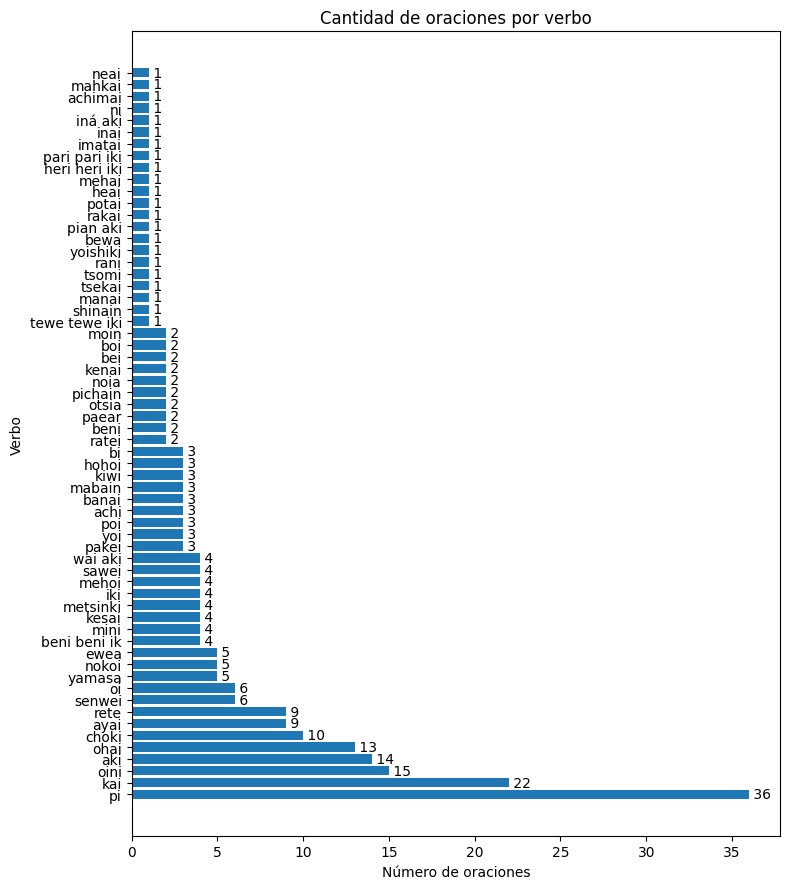

In [1264]:
import pandas as pd
import matplotlib.pyplot as plt

# Crear una columna con el número de oraciones para cada verbo
grouped_data_df['sentence_count'] = grouped_data_df['inflected_forms'].apply(len)

# Ordenar de mayor a menor cantidad de oraciones
grouped_data_df = grouped_data_df.sort_values(by='sentence_count', ascending=False)

# Graficar la cantidad de oraciones por verbo con barras horizontales
plt.figure(figsize=(8, 9))
bars = plt.barh(grouped_data_df['verb'], grouped_data_df['sentence_count'])

# Agregar los valores al final de cada barra
for bar in bars:
    plt.text(
        bar.get_width(),    # Posición en el eje X
        bar.get_y() + bar.get_height() / 2,  # Posición en el eje Y
        f' {int(bar.get_width())}',  # Valor a mostrar
        va='center'  # Alinear verticalmente el texto
    )

plt.xlabel('Número de oraciones')
plt.ylabel('Verbo')
plt.title('Cantidad de oraciones por verbo')
plt.tight_layout()

# Mostrar el gráfico
plt.show()


In [1265]:
print(", ".join(grouped_data_df['verb']))


pi, kai, oini, aki, ohai, choki, ayai, rete, senwei, oi, yamasa, nokoi, ewea, beni beni ik, mini, kesai, metsinki, iki, mehoi, sawei, wai aki, pakei, yoi, poi, achi, banai, mabain, kiwi, hohoi, bi, ratei, beni, paear, otsia, pichain, noia, kenai, bei, boi, moin, tewe tewe iki, shinain, manai, tsekai, tsomi, rani, yoishiki, bewa, pian aki, rakai, potai, heai, mehai, heri heri iki, pari pari iki, imatai, inai, iná aki, ni, achimai, mahkai, neai


In [ ]:
grouped_data_df.to_json("json/isc_verbs_data.json", orient="records", force_ascii=False)

In [ ]:
grouped_data_df = pd.read_json("json/isc_verbs_data.json")

# Crear un df con las columnoas verb y sentences
# En la columna sentences, se debe tener una lista de opraciones con las en suffix_sentence
new_df = []

for _, row in grouped_data_df.iterrows():
    verb = row['verb']
    sentences = [sentence['suffix_sentence'] for sentence in row['inflected_forms']]
    # Eliminar duplicados
    sentences = list(set(sentences))

    new_df.append({'verb': verb, 'inflected_forms': sentences})

new_df = pd.DataFrame(new_df)

# ordenar por cantidad de oraciones en sentences
new_df['sentence_count'] = new_df['inflected_forms'].apply(len)
new_df = new_df.sort_values(by='sentence_count', ascending=False)

new_df.to_csv("../csv/isc_verbs_sentences.csv", index=False)

## Generar Input model

In [ ]:
df = pd.read_json('json/isc_verbs_data.json')

In [1269]:
import pandas as pd
from collections import defaultdict


# Crear un diccionario para almacenar todas las abreviaciones únicas por cada característica
morph_abbreviations = defaultdict(set)

# Recorrer cada verbo y sus formas flexionadas
for verb_data in df['inflected_forms']:
    for form in verb_data:
        for feature, abbreviations in form['morph_features'].items():
            # Agregar cada abreviación al conjunto correspondiente en morph_abbreviations
            morph_abbreviations[feature].update(abbreviations)

# Convertir el conjunto en lista para cada característica y ordenar las abreviaciones
morph_abbreviations = {feature: sorted(list(abbrevs)) for feature, abbrevs in morph_abbreviations.items()}

# Mostrar el mapeo de abreviaciones únicas por característica
for feature, abbrevs in morph_abbreviations.items():
    print(f"{feature}: {abbrevs}")


transitivity: ['TRAN']
aspect: ['EST', 'HAB', 'IMPF', 'PERF', 'PFV', 'PROG']
tense: ['DUR.mismo.día', 'FUT.INM', 'PAS.REM', 'PAS.REM.DUR', 'PAS.REM.HAB', 'PAS.ayer', 'PAS.días', 'todavía']
mood: ['ASER', 'DES', 'DUB', 'HAB', 'IMP']
number: ['DUAL', 'PLU']
negation: ['FRUS', 'NEG', 'nunca', 'todavía.no']
movement: ['ANDA', 'DUR', 'ITER', 'VEN', 'bajando', 'dando.vuelta', 'ir.a', 'pasando', 'subiendo']
reference_change: ['S/A>A', 'S/A>S']
other: ['ASOC', 'BEN', 'CAUS', 'DIM', 'ENF', 'MAL', 'REC']


In [ ]:
# Definir el mapeo de UniMorph
unimorph_mapping = {
    'transitivity': {'TRAN': 'TR', 'INT': 'INTR'},
    'aspect': {'IMPF': 'IPFV', 'PERF': 'PFV', 'PF': 'PFV', 'HAB': 'HAB_A', 'EST': 'POT', 'PROG': 'PRG', 'IPFV': 'IPFV'},
    'tense': {'Pres': 'PRS', 'PAS': 'PST', 'FUT': 'FUT',  'FUT.INM': 'FUT.INM', 'PAS.REM': 'PST.REM', 'PAS.días': 'PST.days', 'PAS.ayer': 'PST.yesterday', 'todavía':  'PST.yet', 'DUR.mismo.día': 'PST.DUR' },
    'mood': {'IND': 'IND', 'SUBJ': 'SBJV', 'IMP': 'IMP', 'HAB': 'HAB_M', 'Sub': 'SBJV', 'ASER': 'ASER', 'DUB': 'DUB', 'DES': 'DES'},
    'number': {'Sing': 'SG', 'Plur': 'PL', 'DUAL': 'DUAL', 'PLU': 'PL'},
    # negation: ['FRUS', 'NEG', 'nunca', 'todavía.no']
    'negation': {'NEG': 'NEG', 'FRUS': 'NEG.FRUS', 'nunca': 'NEG.never', 'todavía.no': 'NEG.yet'},
    # movement: ['ANDA', 'DUR', 'ITER', 'VEN', 'bajando', 'dando.vuelta', 'ir.a', 'pasando', 'subiendo']
    'movement': {'ANDA': 'MOV.ANDA', 'DUR': 'MOV.DUR', 'ITER': 'MOV.ITER', 'VEN': 'MOV.VEN',
                 'bajando': 'MOV.down', 'dando.vuelta': 'MOV.around', 'ir.a': 'MOV.goto',
                 'pasando': 'MOV.passing', 'subiendo': 'MOV.up'},
    # reference_change: ['S/A>A', 'S/A>S']
    'reference_change': {'S/A>A': 'REF.S/A>A', 'S/A>S': 'REF.S/A>S'},
    # other: ['BEN', 'DIM', 'ENF', 'MAL']
    'other': {'ASOC': 'ASOC', 'BEN': 'BEN', 'DIM': 'DIM', 'ENF': 'ENF', 'MAL': 'MAL', 'CAUS': 'CAUS'}
}

# Función para mapear características a etiquetas UniMorph usando 'morph_abbreviations'
def map_features_to_unimorph(features):
    tags = []
    for feature, values in features.items():
        if feature in unimorph_mapping:
            for value in values:
                # Verificar si el valor está en el mapeo y agregar la etiqueta correspondiente
                if value in unimorph_mapping[feature]:
                    tags.append(unimorph_mapping[feature][value])
                else:
                    tags.append(value)
    tags.insert(0, 'V')  # Asumimos que todos son verbos
    return ';'.join(tags)

# Crear una lista para almacenar los registros
records = []

# Iterar sobre el DataFrame y procesar cada fila
for index, row in df.iterrows():
    lemma = row['verb']
    inflected_forms = row['inflected_forms']
    
    # Verificar si 'inflected_forms' es una lista y no está vacía
    if isinstance(inflected_forms, list) and len(inflected_forms) > 0:
        for form in inflected_forms:
            inflected_verb = form['iskonawa_verb']
            morph_features = form['morph_features']
            
            # Mapear las características a etiquetas UniMorph
            tags = map_features_to_unimorph(morph_features)
            
            # Agregar el registro a la lista
            records.append({'lemma': lemma, 'inflected_form': inflected_verb, 'unimorph_tags': tags})

# Crear un nuevo DataFrame con los registros
unimorph_df = pd.DataFrame(records)

# Quedarme con valores únicos
print("Cantidad de registros antes de eliminar duplicados:", len(unimorph_df))
unimorph_df = unimorph_df.drop_duplicates()
print("Cantidad de registros después de eliminar duplicados:", len(unimorph_df))

# Quedarme con valores que tienen features
unimorph_df = unimorph_df[unimorph_df['unimorph_tags'] != 'V']
print("Cantidad de registros con características:", len(unimorph_df))

# Escribir el DataFrame a un archivo de texto en formato UniMorph
unimorph_df.to_csv('../data/unimorph_output.tsv', sep='\t', index=False, header=False)

print("Archivo UniMorph generado exitosamente.")

Cantidad de registros antes de eliminar duplicados: 256
Cantidad de registros después de eliminar duplicados: 184
Cantidad de registros con características: 179
Archivo UniMorph generado exitosamente.
